In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import special

In [146]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
		"font.size": 14
		})

# Dispersion analysis

## Dispersion coefficients vs velocity

In [97]:
# constants
e = 1.602e-19
epsilon0 = 8.854e-12
me = 9.109e-31

# values
v0 = 1.84142e7
dt = 93e-3 * 0.002

q1 = e
q2 = e
ma = 1836 * me
nb = 1e20
lnLambda = 17.5
vsb = 1.61029 * v0



In [87]:
def G(x):
	return (special.erf(x) - 2 * x * np.exp(-x**2) / np.sqrt( np.pi )) / (2 * x**2)

In [91]:
Ad = q1**2 * q2 ** 2 * nb * lnLambda  / (2 * np.pi * epsilon0**2 * ma**2) 

def D_par(v):
	return Ad * G(v/vsb) / (v)

def D_perp(v):
	return Ad *(special.erf(v/vsb) - G(v/vsb)) / (v)

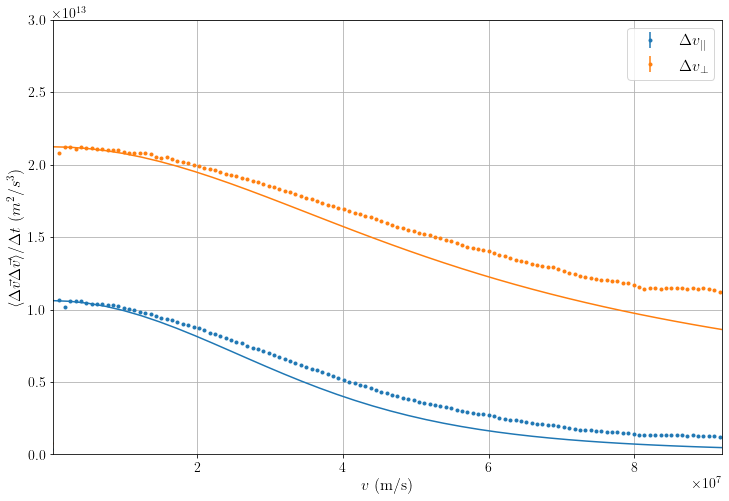

In [106]:
dir = '/home/michel/Documents/Minimal/build/dispersion_only/onlydv'
filename = 'process_disp_out.dat'

data = np.loadtxt(f'{dir}/{filename}')
v = data[:,0] * v0
par = data[:,1] * v0**2 / dt
perp = data[:,2] * v0**2 / dt

verr = data[:,3] * v0
parerr = data[:,4] * v0**2 / dt
perperr = data[:,5] * v0**2 / dt

nvs = data[:,6]

fig = plt.figure()
ax = fig.add_subplot(111)

x = np.linspace(0.01 * v0, 6.5 * v0)
d_par = D_par(x)
d_perp = D_perp(x)


ax.errorbar(v, par, yerr=parerr, fmt='.', label='$\Delta v_{||}$')
ax.errorbar(v, perp, yerr=perperr, fmt='.', label='$\Delta v_\perp$')
# ax.scatter(v, par, label='parallel')
# ax.scatter(v, perp, label='perpendicular')

# theoretical curves
ax.set_prop_cycle(None) # reset color cycle
ax.plot(x, d_par)
ax.plot(x, d_perp)

# ax.bar(v, - nvs * 5e12/8000, bottom=7.4e13, color='k')

# ax.grid()
plt.legend(fontsize=16)
plt.rcParams['figure.figsize'] = [12, 8]

ax.set_ylim([0, 3e13])
ax.set_xlim([0.01* v0, 5 * v0])
ax.grid()
ax.set_xlabel('$v$ (m/s)', fontsize=16)
ax.set_ylabel('$\langle \Delta \\vec{v} \Delta \\vec{v} \\rangle / \Delta t \ (m^2/s^3)$', fontsize=16)

fig.savefig('difusion_coeff.pdf')

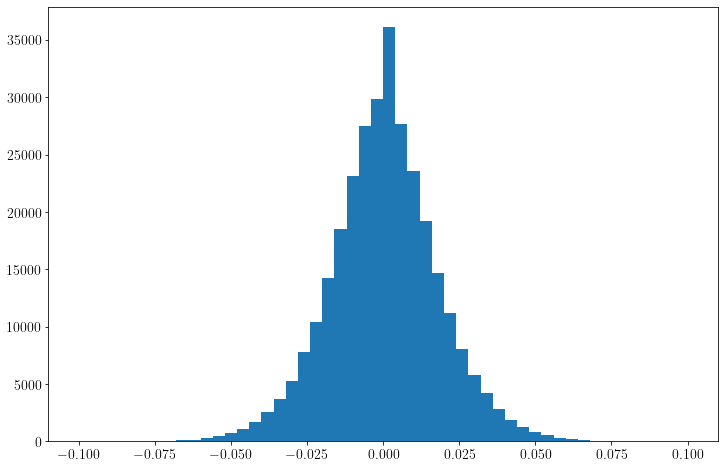

In [9]:
dir = '/home/michel/Documents/Minimal/build/dispersion_only/cart'
filename = 'differences.dat'

data = np.loadtxt(f'{dir}/{filename}')
par = data[:,0]

plt.hist(par, 50, range=(-0.1, 0.1))

plt.show()

### Plotting some velocity trajectories for presenting

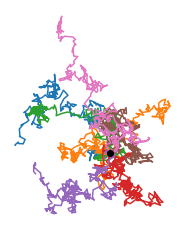

In [13]:
%matplotlib inline
dir = '/home/michel/Documents/Minimal/build/dispersion_only/onlydv'

fig = plt.figure()
ax = fig.add_subplot(111)

for i in [1, 3, 4, 5, 6, 7, 8]:
	data = np.loadtxt(f'{dir}/{i}.dat', max_rows=300)
	vx = data[:,4]
	vy = data[:,5]

	ax.plot(vx, vy)

ax.scatter([0], [0], color='k', zorder=100)

ax.axis('off')
ax.set_aspect('equal', adjustable='box')

fig.savefig('vdisp.svg', bbox_inches='tight')





# Slowing down

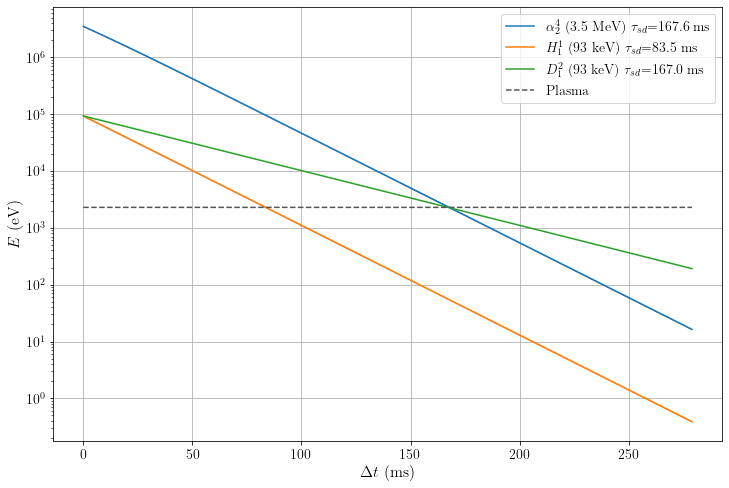

In [85]:
v0 = 1.29477e7
tau = 93 # in ms

E_plas = 2290


dir = '/home/michel/Documents/Minimal/build'

for (fname, label, m) in [('slowing_down_alpha.dat', '$\\alpha^4_2$ (3.5 MeV)', 4), ('slowing_down.dat', '$H^1_1$  (93 keV)', 1), ('slowing_down_D_93kev.dat', '$D^2_1$  (93 keV)', 2)]:
	data = np.loadtxt(f'{dir}/{fname}')
	t = data[:,0] * tau
	vz = data[:,6]
	E = (0.5 * m * 1836 * me * (vz * v0) ** 2)/e

	ts = 0
	for i in range(len(E)):
		if E[i] < E_plas:
			ts = t[i]
			break
	
	true_label = label + '      $\\tau_{sd}$' + f'={ts:#.1f} ms'

	plt.semilogy(t , E, label=true_label)

plt.semilogy(t, [E_plas] * len(t), color='#555', ls='--', label='Plasma')

plt.rcParams['figure.figsize'] = [12, 8]

plt.grid()
plt.xlabel('$\Delta t$ (ms)', fontsize=16)
plt.ylabel('$E$ (eV)', fontsize=16)
plt.legend()
plt.savefig('slowing_down.pdf')

# Slowing and dispersion

In [149]:
%matplotlib qt

dir = '/home/michel/Documents/Minimal/build/collisions/cart'

a = 0.5/1000 # in km
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(1, 200):
	if (i == 30 or i == 479): continue # REVIEW THIS!! Something weird happens with seeds 30, 479

	data = np.loadtxt(f'{dir}/{i}.dat')

	x = data[:,1] * a
	y = data[:,2] * a
	z = data[:,3] * a

	ax.plot(x, y, z)

ax.w_xaxis.set_pane_color((1, 1, 1, 0))
ax.w_yaxis.set_pane_color((1, 1, 1, 0))
ax.w_zaxis.set_pane_color((1, 1, 1, 0))

# ax.set_xticks([0])
# ax.set_yticks([0])
# ax.set_zticks([0, 100])

ax.set_xlabel('x (m)', fontsize=16)
ax.set_ylabel('y (m)', fontsize=16)
ax.set_zlabel('z (m)', fontsize=16)

Text(0.5, 0, 'z (m)')